In [1]:
%matplotlib inline  
import numpy as np
import preprocessing_SDSSv2 as pp
from sklearn import preprocessing
import pylab as pl
from sklearn.model_selection import StratifiedShuffleSplit
pl.ion()

In [2]:
from matplotlib import pyplot as plt

from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import RandomizedPCA
from scipy.stats import norm
from scipy import interpolate

In [3]:
import variationalAutoencoderv3 as VAE

In [4]:
xx = np.linspace(-3,3,1000)
cnt = 6*(np.random.rand(4000)-.5)
#cnt = np.linspace(-3,3,4000)
X = np.empty((4000,1000),dtype=np.float32)
for ii in range(4000):
    pp = norm.pdf(xx, cnt[ii],.4)+0.05*np.random.randn(1,1000)
    X[ii]=0.1+0.8*((pp-pp.min())/(pp.max()-pp.min()))
wavelength = xx
Xtrain = X

## Dataset

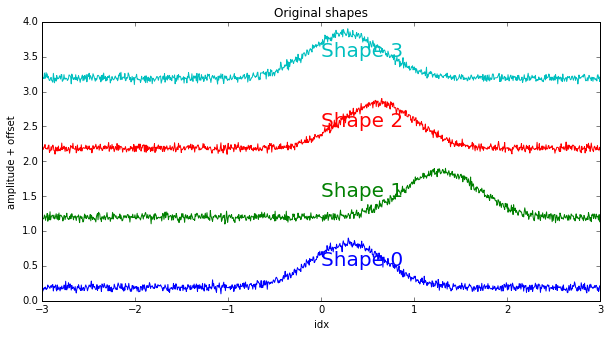

In [5]:
fig = plt.figure(figsize=(10, 5))
for ii in range(4):
    l = plt.plot(wavelength, X[ii]+1*ii)
    c = l[0].get_color()
    plt.text(0,  0.5+1 * ii,"Shape %d" % ii, color=c,fontsize=20)
plt.subplots_adjust(hspace=0)
plt.xlabel('idx')
plt.ylabel('amplitude + offset')
plt.title('Original shapes')

In [6]:
n_z=2
n_components = 5
vaeX = VAE.VariationalAutoencoder(training_epochs=1000,n_z=n_z,nameFileOutMatrixNumpy='ExampleGaussianMoveCenter')
#vaeX.train(Xtrain)
vaeX.restore('ExampleGaussianMoveCenter')
zlat = vaeX.transform(X)
Xpred = vaeX.reconstruct(X)
idx_best = np.argsort(-1*np.sum(np.absolute(zlat)>0.5,axis=0))
nx = ny = 11
x_values = np.linspace(np.floor(zlat[:,idx_best[0]].min()), np.ceil(zlat[:,idx_best[0]].max()), nx)
y_values = np.linspace(np.floor(zlat[:,idx_best[1]].min()), np.ceil(zlat[:,idx_best[1]].max()), ny)
xv, yv = np.meshgrid(x_values, y_values)
Zgrid = np.zeros((nx*ny ,n_z),dtype=np.float32)
Zgrid[:, idx_best[0]] = xv.ravel()
Zgrid[:, idx_best[1]] = yv.ravel()
Xgrid = vaeX.generate(Zgrid)
Zcomp = np.zeros((2*n_z + 1, n_z),dtype=np.float32)
Xcomp = np.zeros((2*n_z + 1, Xtrain.shape[1]), dtype=np.float32)
Xcomp[0] = vaeX.generate(Zcomp[0].reshape(1,-1))
count = 1
for ii in range(n_z):
    Zcomp[count][ii] = 1
    Xcomp[count] = vaeX.generate(Zcomp[count].reshape(1,-1))
    count = count + 1
for ii in range(n_z):
    Zcomp[count][ii] = -1
    Xcomp[count] = vaeX.generate(Zcomp[count].reshape(1,-1))
    count = count + 1
RD = np.empty((n_components,len(Xcomp[0])),dtype=np.float32)
RD[0] = Xcomp[0]
for ii in range(4):
    RD[ii+1] = Xcomp[ii+1] - Xcomp[0]
#decompositions.append(RD)
nmf2 = NMF(n_components)
nmf2.fit(Xgrid)
nmf2_comp = nmf2.components_
#decompositions.append(nmf2_comp)

INFO:tensorflow:Restoring parameters from temp\ExampleGaussianMoveCenter\model.ckpt
Model restored.


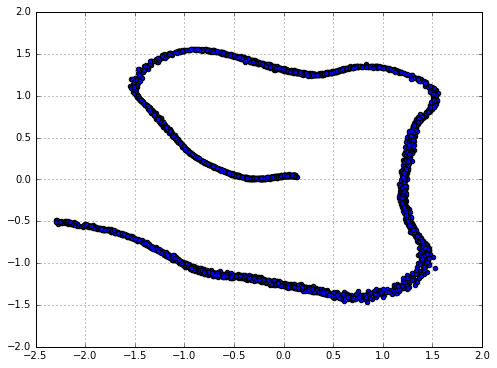

In [31]:
plt.figure(figsize=(8, 6)) 
plt.scatter(zlat[:, [0]], zlat[:, [1]])
plt.grid()

(array([  21.,   19.,   35.,   30.,   37.,   49.,  129.,  150.,  167.,
         154.,  148.,  132.,  133.,  149.,  164.,  172.,  196.,  208.,
         203.,  123.,  121.,  114.,  100.,   62.,   41.,   48.,   38.,
         646.,  275.,  136.]),
 array([-2.29037762, -2.16230013, -2.03422264, -1.90614516, -1.77806767,
        -1.64999018, -1.52191269, -1.39383521, -1.26575772, -1.13768023,
        -1.00960275, -0.88152526, -0.75344777, -0.62537028, -0.4972928 ,
        -0.36921531, -0.24113782, -0.11306034,  0.01501715,  0.14309464,
         0.27117213,  0.39924961,  0.5273271 ,  0.65540459,  0.78348207,
         0.91155956,  1.03963705,  1.16771454,  1.29579202,  1.42386951,
         1.551947  ]),
 <a list of 30 Patch objects>)

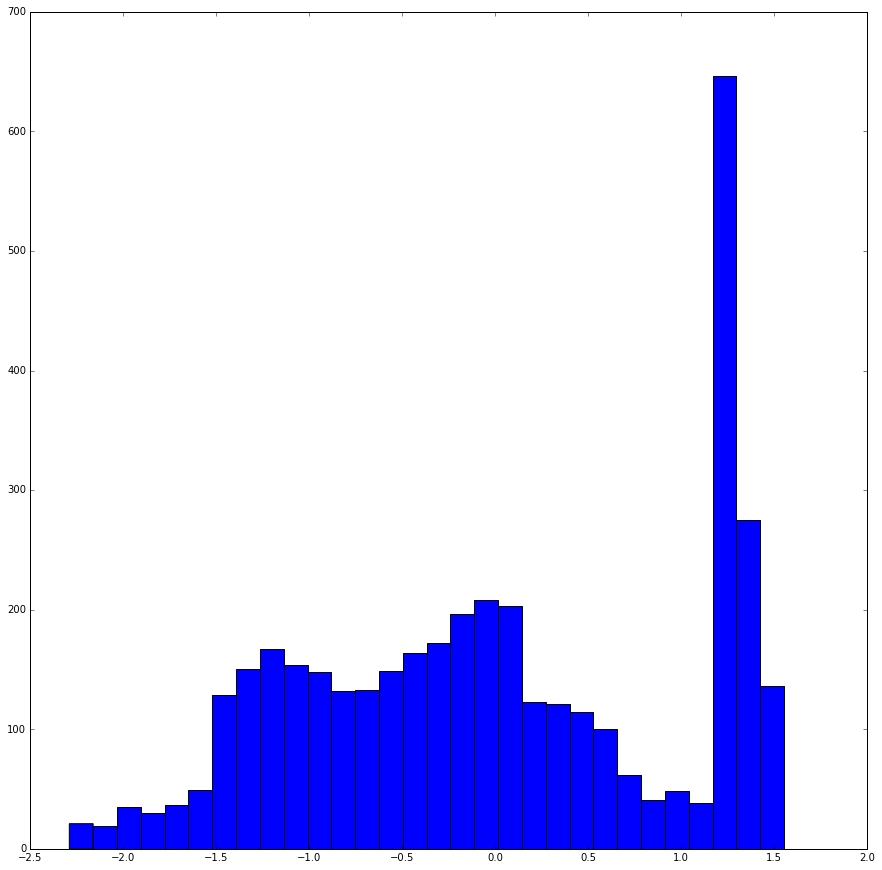

In [40]:
plt.figure(figsize=(15,15))
xx = np.arange(zlat.shape[1])
# for ii in range(zlat.shape[0]):
#     plt.scatter(xx,zlat[ii])
plt.hist(zlat[:,0],bins=30)   

Exception ignored in: <bound method MatplotView.__del__ of <umatrix_vae.UMatrixView object at 0x00000031ADFCB5C0>>
Traceback (most recent call last):
  File "C:\Users\Atila1\Desktop\FOD_2\SDSSv2\umatrix_vae.py", line 41, in __del__
    self._close_fig()
  File "C:\Users\Atila1\Desktop\FOD_2\SDSSv2\umatrix_vae.py", line 44, in _close_fig
    if self._fig:
AttributeError: 'UMatrixView' object has no attribute '_fig'


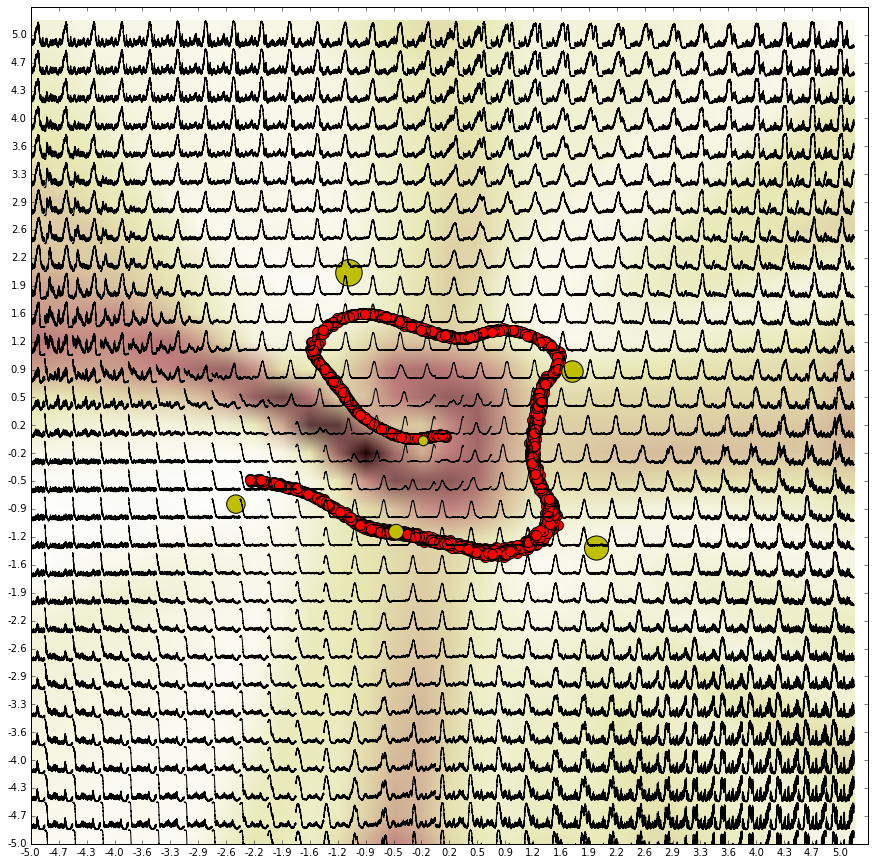

In [30]:
import umatrix_vae as umvae
grid=[30,30]
limitLattice = [-5,5,-5,5]
s=umvae.UMatrixView(limitLattice=limitLattice,grid=grid)
s.data_latent = vaeX.transform(X)
s.data_original = X
s.Xgrid = vaeX.generate(s.Zgrid.T)
#A=s.show(show_data=False)
#plt.imshow(A, cmap=plt.cm.get_cmap('RdYlBu_r'), alpha=1)
zzgrid_unit = s.Zgrid_unit.T
zzgrid = s.Zgrid.T
xxgrid = s.Xgrid
plt.figure(figsize=(15,15))
plt.imshow(s.build_u_matrix(), cmap=plt.cm.get_cmap('pink_r'), alpha=1,origin='lower')
xx = np.linspace(-0.5, 0.5, len(wavelength))
count = 0
xzgrid = list()
yzgrid = list()
for i in range(s.nnodes):
    xzgrid.append(zzgrid_unit[count, 0]+xx)
    xzgrid.append(np.nan)
    yzgrid.append(xxgrid[count]-0.5+zzgrid_unit[count, 1])
    yzgrid.append(np.nan)
    #plt.plot(zzgrid_unit[count, 0]+xx,xxgrid[count]-0.5+zzgrid_unit[count, 1],'k')
    count = count + 1
xzgrid_vec = np.hstack(xzgrid)
yzgrid_vec = np.hstack(yzgrid)
plt.plot(xzgrid_vec,yzgrid_vec,'k')
nmf2 = NMF(6)
nmf2.fit(xxgrid)
nmf2_comp = nmf2.components_
nmf2_comp.shape
zzcompNMF = vaeX.transform(nmf2_comp)
f1 = interpolate.interp1d(s.Zgrid[1,np.arange(0,s.nnodes,s.grid[1])],s.Zgrid_unit[1,np.arange(0,s.nnodes,s.grid[1])],fill_value='extrapolate')
f0 = interpolate.interp1d(s.Zgrid[0,:s.grid[0]],s.Zgrid_unit[0,:s.grid[0]],fill_value='extrapolate')
plt.scatter(f0(zlat[:,0]),f1(zlat[:,1]),s=100,c='r')
plt.scatter(f0(zzcompNMF[:,0]),f1(zzcompNMF[:,1]),s=np.linspace(700,100,zzcompNMF.shape[0]),c='y')
plt.xlim([0,grid[0]])
plt.ylim([0,grid[1]])
plt.xticks(s.Zgrid_unit[0,:s.grid[0]],np.round(s.Zgrid[0,:s.grid[0]],1))
plt.yticks(s.Zgrid_unit[1,np.arange(0,s.nnodes,s.grid[1])],np.round(s.Zgrid[1,np.arange(0,s.nnodes,s.grid[1])],1))
plt.show()

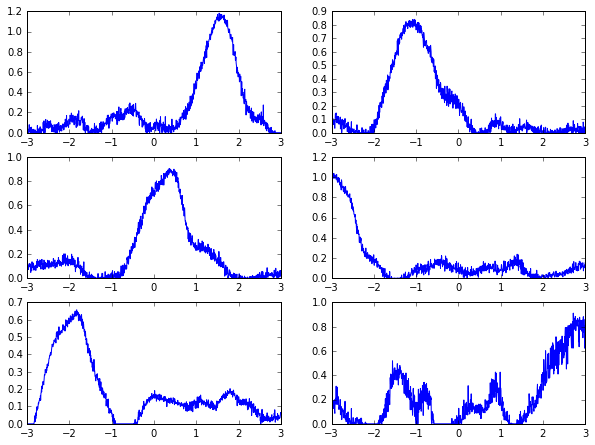

In [32]:
ncomp = nmf2_comp.shape[0]
ncomp1 = int(np.sqrt(ncomp))
ncomp2 = ncomp-ncomp1
plt.figure(figsize=(10,10))
for i in range(ncomp):
    plt.subplot(ncomp2,ncomp1,i+1)
    plt.plot(wavelength,nmf2_comp[i])
plt.show()

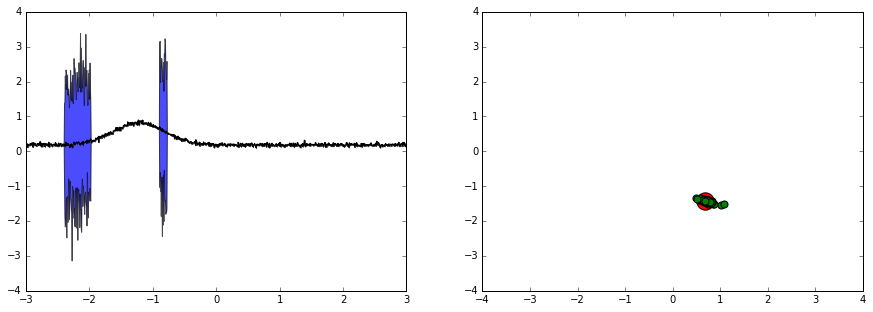

In [28]:
#vaeX.transform(X)
g = X[450].copy()
a1=vaeX.transform(g.reshape(1,-1))
a2 = np.zeros((100,1000))
a3 = np.zeros((100,2))
idx = np.arange(350,370)
idx2 = np.arange(100,170)
#plt.scatter(wavelength,g,s=100,c='r')
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(a1[0,0],a1[0,1],s=300,c='r')
for i in range(100):
    a2[i] = g
    a2[i,idx]=g[idx]+np.random.rand()*np.random.randn(len(g[idx]))
    a2[i,idx2]=g[idx2]+np.random.rand()*np.random.randn(len(g[idx2]))
    a3[i] = vaeX.transform(a2[i].reshape(1,-1))
    plt.scatter(a3[i,0],a3[i,1],s=50,c='g')
    #plt.scatter(wavelength,a2[i],s=50,c='g')
plt.xlim([limitLattice[0],limitLattice[1]])
plt.ylim([limitLattice[2],limitLattice[3]]))

plt.subplot(1,2,1)
pl.plot(wavelength,g, 'k-')
pl.fill_between(wavelength, a2.min(axis=0), a2.max(axis=0),alpha=0.7)

plt.show()



In [15]:
#vaeX.save('ExampleGaussianMoveCenter')

Model saved in folder: temp/ExampleGaussianMoveCenter
